<center><h1>Reconaissance d'une expression Facial<h1/><center>


<p>La reconnaissance des émotions faciales (communément appelée RFE) est l'un des domaines de la vision par ordinateur les plus étudiés à ce jour et fait encore l'objet d'évaluations et d'améliorations continues. L'idée est la suivante : pouvons-nous détecter l'émotion d'une personne par ses expressions faciales ? 
<p>Bien sûr, en tant qu'être humain, nous pouvons très facilement le faire et, en fait, nous le faisons des milliers de fois par jour. Mais pouvons-nous rendre nos machines suffisamment intelligentes pour qu'elles puissent également atteindre des performances de niveau humain dans ces tâches de reconnaissance des émotions ? Vous voyez, parce que nous, les humains, avons des émotions, c'est pourquoi nous sommes facilement capables de détecter les émotions des autres, mais ce n'est pas le cas des machines.
<p>Les progrès dans le domaine de la vision par ordinateur montent en flèche, ces tâches ne sont plus si difficiles, au moins nous sommes capables d'atteindre de bonnes performances avec très peu d'efforts. Nous allons voir comment cela peut être fait avec quelques lignes de code python.



<p>Les données sont constituées d’images de faces en niveaux de gris de 48x48 pixels. Les faces ont été automatiquement enregistrées de sorte que le visage est plus ou moins centré et occupe environ la même quantité d’espace dans chaque image. La tâche consiste à classer chaque visage en fonction de l’émotion de l’expression faciale dans l’une des sept catégories suivantes :

In [1]:
emotions = {0: 'Angry', 1: 'Disgust', 2: 'Fear', 3: 'Happy', 4: 'Sad', 5: 'Surprise', 6: 'Neutral'}

<table align="left">
<thead><tr>
<th style="text-align:center">categorie</th>
<th style="text-align:left">emotion</th>
</tr>
</thead>
<tbody>
<tr>
<td style="text-align:center">0</td>
<td style="text-align:left">Angry</td>
</tr>
<tr>
<td style="text-align:center">1</td>
<td style="text-align:left">Disgust</td>
</tr>
<tr>
<td style="text-align:center">2</td>
<td style="text-align:left">Fear</td>
</tr>
<tr>
<td style="text-align:center">3</td>
<td style="text-align:left">Happy</td>
</tr>
<tr>
<td style="text-align:center">4</td>
<td style="text-align:left">Sad</td>
</tr>
<tr>
<td style="text-align:center">5</td>
<td style="text-align:left">Surprise</td>
</tr>
<tr>
<td style="text-align:center">6</td>
<td style="text-align:left">Neutral</td>
</tr>
</tbody>
<table>

<center><h2>Importation des packages<h2/><center/>

In [2]:
import pandas as pd
import numpy as np
import tensorflow as tf
import os
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from mlxtend.plotting import plot_confusion_matrix

from tensorflow import keras
from keras import models
from tensorflow.keras import layers
from keras.utils import to_categorical
from keras.layers import Input, Dense, Flatten, Dropout, BatchNormalization,Conv2D,MaxPooling2D
from keras.optimizers import RMSprop,Adam
from keras.preprocessing.image import img_to_array
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dropout, BatchNormalization, LeakyReLU, Activation
from tensorflow.keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator


<center><h2>Visualisation de données<h2/><center/>

In [3]:
data = pd.read_csv('icml_face_data.csv')

In [4]:
data.head()

,emotion,Usage,pixels
0,0,Training,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...
1,0,Training,151 150 147 155 148 133 111 140 170 174 182 15...
2,2,Training,231 212 156 164 174 138 161 173 182 200 106 38...
3,4,Training,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...
4,6,Training,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...


In [5]:
data.emotion.unique() 
data.emotion.value_counts()

3    8989
6    6198
4    6077
2    5121
0    4953
5    4002
1     547
Name: emotion, dtype: int64

C:\Users\33617\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


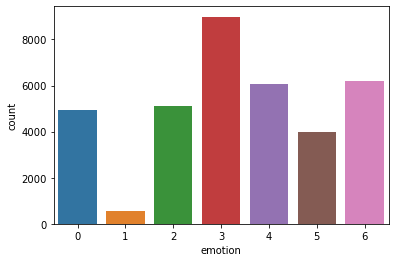

In [6]:
import seaborn as sns
sns.countplot(data.emotion)
plt.show()

In [7]:
data.columns

Index(['emotion', ' Usage', ' pixels'], dtype='object')

In [8]:
(data[data.emotion==3].shape,data[data.emotion==4].shape,data[data.emotion==6].shape)

((8989, 3), (6077, 3), (6198, 3))

In [9]:
def parse_data(data):
    image_array = np.zeros(shape=(len(data), 48, 48, 1))
    image_label = np.array(list(map(int, data['emotion'])))
    
    for i, row in enumerate(data.index):
        image = np.fromstring(data.loc[row, ' pixels'], dtype=int, sep=' ')
        image = np.reshape(image, (48, 48, 1))
        image_array[i] = image
        
    return image_array, image_label

In [10]:
train_images, train_labels = parse_data(data[data[" Usage"] == "Training"])
val_images, val_labels = parse_data(data[data[" Usage"] == "PrivateTest"])
test_images, test_labels = parse_data(data[data[" Usage"] == "PublicTest"])

In [11]:
train_labels = to_categorical(train_labels)
val_labels = to_categorical(val_labels)
test_labels = to_categorical(test_labels)

In [12]:
#On normalise les valeurs pour faciliter les calculs sur les réseaux neuronnaux.
train_images=train_images/255
val_images=val_images/255
test_images=test_images/255

Text(0.5, 1.0, 'Fear')

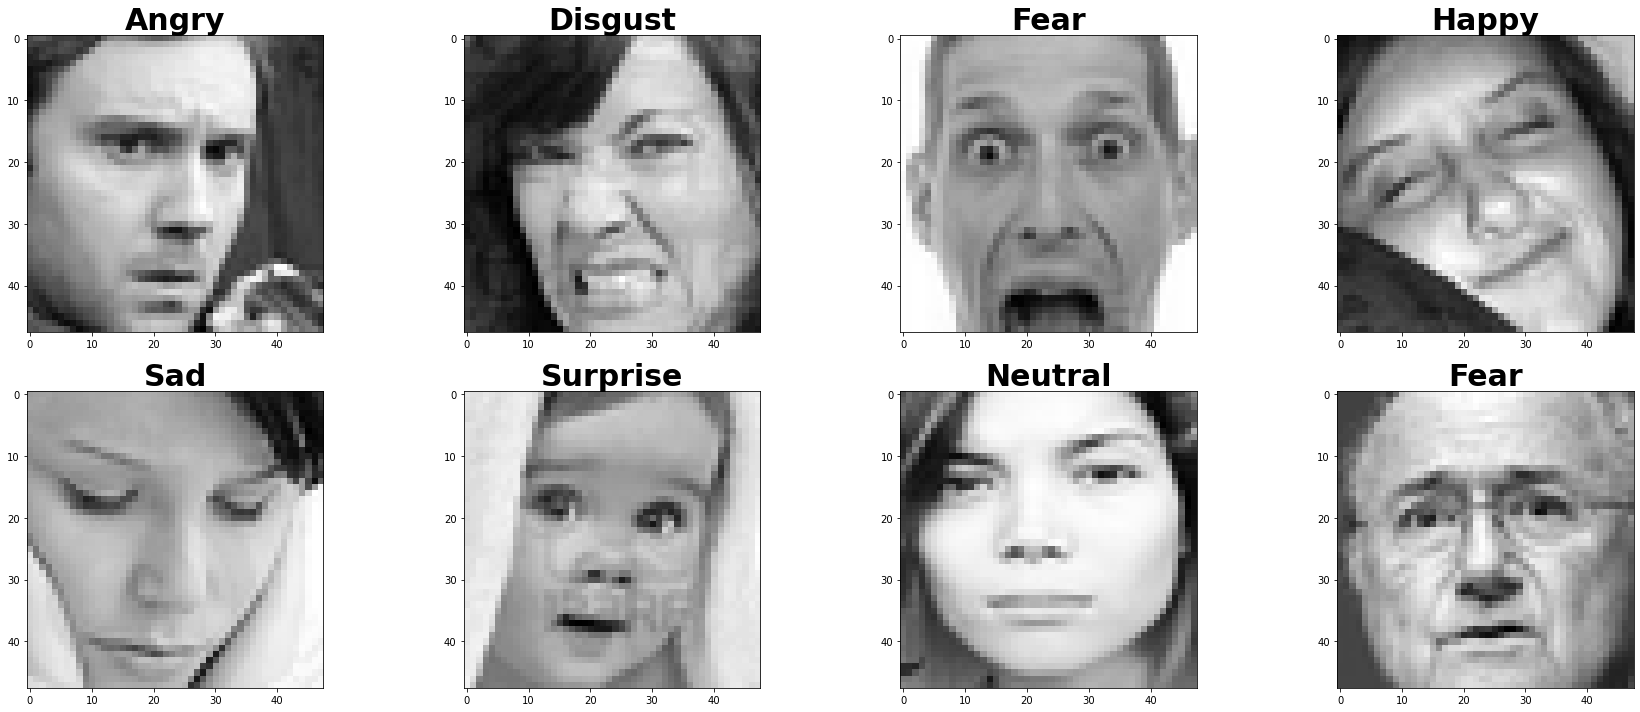

In [13]:
fig, axs = plt.subplots(2, 4, figsize=(30, 12))
fig.subplots_adjust(hspace = .2, wspace=.2)
axs = axs.ravel()
for i in range(7):
    idx = data[data['emotion']==i].index[i]
    axs[i].imshow(train_images[idx], cmap='gray')
    axs[i].set_title(emotions[train_labels[idx].argmax()], fontdict={'fontsize': 30, 'fontweight': 'bold'})
axs[7].imshow(train_images[5], cmap='gray')
axs[7].set_title(emotions[train_labels[5].argmax()], fontdict={'fontsize': 30, 'fontweight': 'bold'})

In [14]:
test_labels.shape

(3589, 7)

<center><h2>Création du modèle<h2/><center/>

In [15]:
model = keras.Sequential()
model.add(layers.Conv2D(128, (3, 3), activation='selu', input_shape=(48, 48, 1)))
model.add(layers.MaxPool2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='selu'))
model.add(layers.MaxPool2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='selu'))
model.add(layers.MaxPool2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='selu'))
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='selu'))
model.add(layers.Dense(7, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer=keras.optimizers.Adam(lr=1e-3), metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 46, 46, 128)       1280      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 23, 23, 128)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 21, 21, 128)       147584    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 10, 10, 128)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 8, 8, 64)          73792     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 4, 4, 64)          0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 2, 2, 64)          3

In [16]:
Train=model.fit(train_images, train_labels, epochs=15, validation_data=(val_images, val_labels), verbose=1)

Epoch 1/15
898/898 [==============================] - 224s 249ms/step - loss: 1.7036 - accuracy: 0.3319 - val_loss: 1.4331 - val_accuracy: 0.4653
Epoch 2/15
898/898 [==============================] - 223s 248ms/step - loss: 1.4031 - accuracy: 0.4668 - val_loss: 1.3816 - val_accuracy: 0.4756
Epoch 3/15
898/898 [==============================] - 207s 230ms/step - loss: 1.2869 - accuracy: 0.5100 - val_loss: 1.2915 - val_accuracy: 0.5085
Epoch 4/15
898/898 [==============================] - 214s 238ms/step - loss: 1.1819 - accuracy: 0.5505 - val_loss: 1.2785 - val_accuracy: 0.5210
Epoch 5/15
898/898 [==============================] - 203s 226ms/step - loss: 1.0715 - accuracy: 0.5967 - val_loss: 1.2627 - val_accuracy: 0.5188
Epoch 6/15
898/898 [==============================] - 203s 226ms/step - loss: 0.9868 - accuracy: 0.6278 - val_loss: 1.2655 - val_accuracy: 0.5322
Epoch 7/15
898/898 [==============================] - 216s 241ms/step - loss: 0.8846 - accuracy: 0.6694 - val_loss: 1.2824 -

In [17]:
test_preds = model.predict(test_images)

C:\Users\33617\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\33617\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\33617\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\33617\anacond

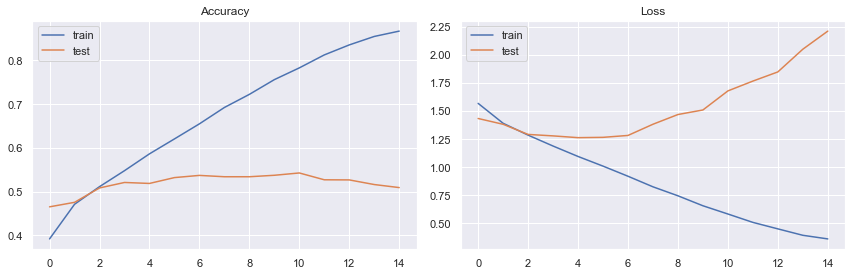

In [18]:
sns.set()
fig = plt.figure(0, (12, 4))

ax = plt.subplot(1, 2, 1)
sns.lineplot(Train.epoch, Train.history['accuracy'], label='train')
sns.lineplot(Train.epoch, Train.history['val_accuracy'], label='test')
plt.title('Accuracy')
plt.tight_layout()

ax = plt.subplot(1, 2, 2)
sns.lineplot(Train.epoch, Train.history['loss'], label='train')
sns.lineplot(Train.epoch, Train.history['val_loss'], label='test')
plt.title('Loss')
plt.tight_layout()

plt.savefig('epoch_train_dcnn.png')
plt.show()

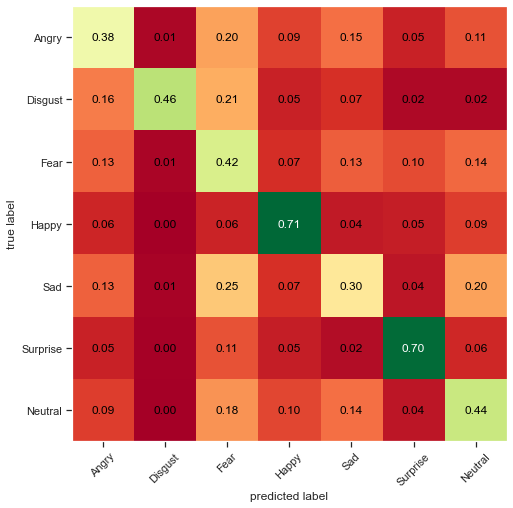

In [19]:
conf_mat = confusion_matrix(test_labels.argmax(axis=1), test_preds.argmax(axis=1))
fig, ax = plot_confusion_matrix(conf_mat=conf_mat,show_normed=True,show_absolute=False,class_names=emotions.values(),figsize=(8, 8),cmap='RdYlGn')

In [20]:
def plot_image_and_emotion(test_images, test_labels, test_preds, image_number):
    fig, axs = plt.subplots(1, 2, figsize=(12, 6), sharey=False)
    bar_label = emotions.values()
    axs[0].imshow(test_images[image_number], 'gray')
    axs[0].set_title(emotions[test_labels[image_number].argmax()])
    
    axs[1].bar(bar_label, test_preds[image_number], alpha=0.7)
    axs[1].grid()
    
    plt.show()

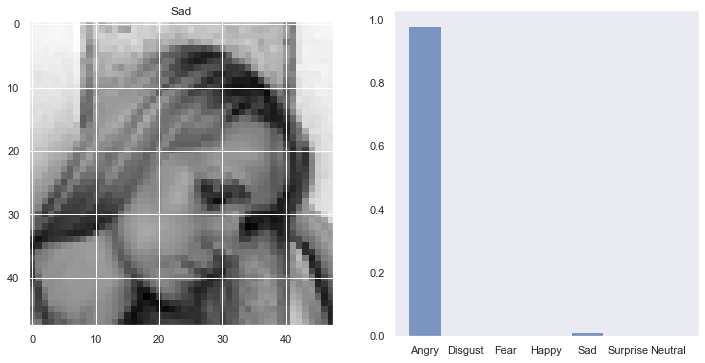

In [21]:
plot_image_and_emotion(test_images, test_labels, test_preds, 54)

In [22]:
from PIL import Image
img1 = Image.open("moi_surpris.jpg").convert(mode='L')
img1 = np.array(img1)
img2 = Image.open("moi_content.jpg").convert(mode='L')
img2 = np.array(img2)
img3 = Image.open("moi_deg.jpg").convert(mode='L')
img3 = np.array(img3)

In [23]:
img=np.array([img1,img2,img3])

In [24]:
pred=model.predict(img.reshape([3,48, 48,1]))

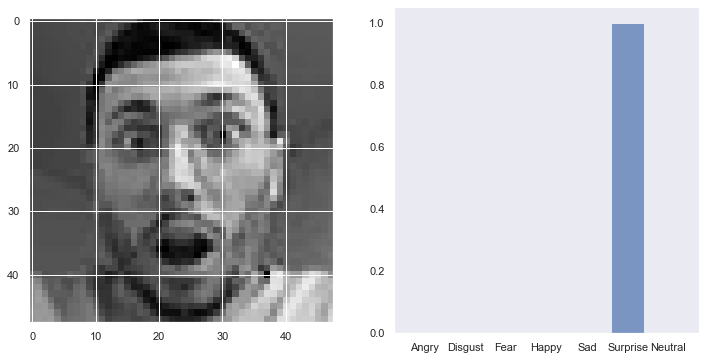

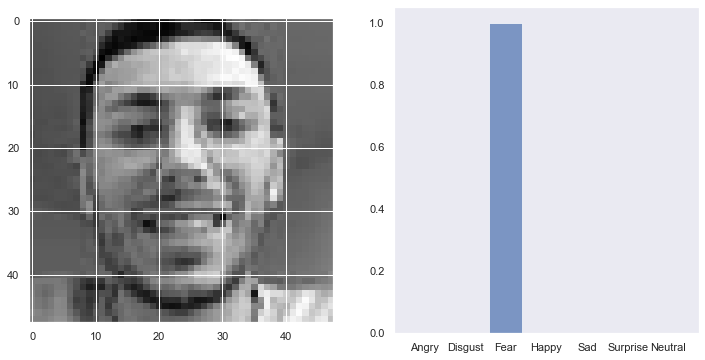

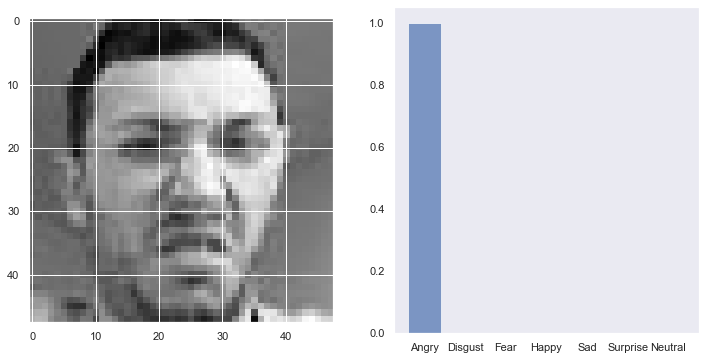

In [25]:
for i in range(3):
    fig, axs = plt.subplots(1, 2, figsize=(12, 6), sharey=False)
    bar_label = emotions.values()
    axs[0].imshow(img[i], 'gray')
    axs[1].bar(bar_label, pred[i], alpha=0.7)
    axs[1].grid()
    plt.show()

<center><h1>Conclusion<h1/><center>


Pour une application industrielle les résultats obtenus ne sont clairement pas assez bons. Mais dans le cadre de notre formation, ces deux exemples fournissent une excellente introduction aux réseaux de neurones. Ils sont l'occasion d'implémenter de toutes pièces des réseaux de neurones, de charger et d'utiliser un réseau pré-entraîné, de se confronter au problème de l'overfitting et de constater l'impact négatif de classes rares (les classes pour lesquelles nous disposons de peu de données).